# Import libraries

In [1]:
# Re-install transformers
# !pip install -q transformers==4.55.4 faiss-cpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, DataLoader

import numpy as np
from safetensors.torch import load_model

In [3]:
from transformers import (
    BertTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    ErnieConfig,
    ErnieModel,
    EarlyStoppingCallback,
)

In [4]:
import gc
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [6]:
from pytorch_metric_learning.losses import SoftTripleLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Set seed for deterministic

In [7]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True) 

# Constants

In [8]:
PATH_TO_DATASET = '/mnt/d/SemEval2026/subtask1'
MODEL_NAME = '/mnt/d/SemEval2026/ernie-3.0-xbase-zh'
BATCH_SIZE_TRAIN = 24
BATCH_SIZE_EVAL = 32

MODEL_PROJECTION_DIM = 256

LANG = 'zho'
NUM_CLASSES = 2
K_FOLDS = 5

SAVE_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-{LANG}'
TEMP_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-temp-{LANG}'

In [9]:
SUBTASK2_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
SUBTASK3_COLUMNS = ['stereotype','vilification','dehumanization','extreme_language','lack_of_empathy','invalidation']

In [10]:
# Training configuration
LEARNING_RATE = 2e-5
MAX_STEPS = 3000
WEIGHT_DECAY = 0.01
LAYER_DECAY = 0.95
WARMUP_RATIO = 0.1
EARLY_STOPPING_PATIENCE = 5
EVAL_STEPS = LOGGING_STEPS = 100
FGM_EPSILON = 0.0

In [11]:
# Soft Triple Loss parameters
SOFT_TRIPLE_LOSS_LA = 20
SOFT_TRIPLE_LOSS_GAMMA = 0.1
SOFT_TRIPLE_LOSS_MARGIN = 0.01

SOFT_TRIPLE_LOSS_CENTERS_PER_CLASS = 10
SOFT_TRIPLE_LOSS_LEARNING_RATE = 1e-2
SOFT_TRIPLE_LOSS_WEIGHT_DECAY = 0.01

# Prepare tokenizer and model

In [12]:
class FGM: # adversarial training
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1.0, emb_name='word_embeddings'):
        # Look for the embedding layer in the model
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                # Save the original embeddings
                self.backup[name] = param.data.clone()
                
                # Calculate the perturbation: noise = epsilon * gradient / norm(gradient)
                if param.grad is not None:
                    norm = torch.norm(param.grad)
                    if norm != 0 and not torch.isnan(norm):
                        r_at = epsilon * param.grad / norm
                        param.data.add_(r_at)

    def restore(self, emb_name='word_embeddings'):
        # Restore the original embeddings
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [13]:
class ErnieSoftTripleModel(nn.Module):
    def __init__(self, model_name='nghuyong/ernie-3.0-xbase-zh', proj_dim=256, load_pretrained_encoder=True):
        super().__init__()
        if load_pretrained_encoder:
            self.encoder = ErnieModel.from_pretrained(model_name)
        else:
            self.encoder = ErnieModel(ErnieConfig.from_pretrained(model_name))
        self.config = self.encoder.config
        self.hidden_size = self.config.hidden_size
        
        self.projection = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.GELU(),
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size, proj_dim)
        )

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # 1. Extract [CLS] Token (Intent)
        cls_embedding = outputs.last_hidden_state[:, 0, :] # [Batch, Hidden]

        # Project to metric space (Stage 1)
        projected = F.normalize(self.projection(cls_embedding), p=2, dim=1)
        cls_embedding = F.normalize(cls_embedding, p=2, dim=1)

        return {'loss': None, 'projected': projected, 'embeddings': cls_embedding}

In [14]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Prepare dataset

In [15]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_length=96):
    """
    Args:
      data: Dict with 'texts', 'labels', and 'ids' keys
    """
    self.tokenizer = tokenizer
    self.max_length = max_length

    if isinstance(data, dict):
      self.texts = data['texts']
      self.labels = data['labels']
      # Add ID support. If not present, generate dummy IDs (0...N)
      self.ids = data.get('ids', list(range(len(self.texts))))
    else:
      raise ValueError("Data must be a single dict with 'texts', 'labels', and 'ids'")

    self.has_labels = any(label is not None for label in self.labels)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx] if self.has_labels else None
    sample_id = self.ids[idx]

    encoding = self.tokenizer(
      text,
      truncation=True,
      padding='max_length', # Changed to max_length for consistent tensor shapes in batch
      max_length=self.max_length,
      return_tensors='pt'
    )

    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    if label is not None:
      item['labels'] = torch.tensor(int(label > 0), dtype=torch.long)
    
    # Return ID so we can verify if needed, though Sampler handles the logic
    item['id'] = sample_id 

    return item

In [16]:
train_path = PATH_TO_DATASET + f'/train/{LANG}.csv'
df = pd.read_csv(train_path)

In [17]:
PATH_TO_DATASET_SUBTASK2 = '/mnt/d/SemEval2026/subtask2'
df_sub2 = pd.read_csv(
    PATH_TO_DATASET_SUBTASK2 + f'/train/{LANG}.csv'
)

In [18]:
df = df.merge(
    df_sub2.drop(columns=['text']),
    on='id',
    how='left'
)

In [19]:
def prepare_data_and_folds(df, df_sub2, n_splits=5, seed=SEED):
    """
    1. Merges Subtask 1 and 2.
    2. Generates 'stage1_target' (0-5) for Metric Learning.
    3. Creates Multilabel Stratified Folds.
    
    Returns: 
        df (updated with 'stage1_target'), 
        fold_idx (list of train/val tuples)
    """
    print(f"Original df shape: {df.shape}")
    
    # --- STEP 2: GENERATE STAGE 1 TARGETS (The Geometry Fix) ---
    # We map Multi-Label vectors to a Single Integer for Triplet Loss.
    # Priority: Gender > Religious > Race > Political > Other
    # Reasoning: 'Gender' is the hardest implicit class. 'Religious' is the smallest minority.
    
    def get_fine_grained_label(row):
        if row['polarization'] == 0:
            return 0  # Class 0: Safe
        
        # Priority Check for Hate Topics
        if row['gender/sexual'] == 1: return 4  # Class 4: Gender (High Priority!)
        if row['religious'] == 1:     return 3  # Class 3: Religious (Protect Minority)
        if row['racial/ethnic'] == 1: return 2  # Class 2: Race (Dominant)
        if row['political'] == 1:     return 1  # Class 1: Politics
        if row['other'] == 1:         return 5  # Class 5: Other
        
        return 5 # Fallback

    print("Generating Fine-Grained Labels for Stage 1...")
    df['polarization'] = df.apply(get_fine_grained_label, axis=1)
    
    # --- STEP 3: STRATIFIED SPLIT (The Variance Fix) ---
    # Stratify on: Main Label + All 5 Topics
    y_main = df['polarization'].values.reshape(-1, 1)
    y_sub2 = df_sub2[SUBTASK2_COLUMNS].values
    stratify_targets = np.hstack([y_main, y_sub2])
    
    print(f"Running Multilabel Stratified K-Fold (n={n_splits})...")
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    fold_idx = []
    for train_idx, val_idx in mskf.split(df, stratify_targets):
        fold_idx.append((train_idx, val_idx))

    # Return the modified DF (so you can access 'stage1_target' later) and the indices
    return df, fold_idx

In [20]:
df, fold_idx = prepare_data_and_folds(df, df_sub2, n_splits=K_FOLDS, seed=SEED)

Original df shape: (4280, 8)
Generating Fine-Grained Labels for Stage 1...
Running Multilabel Stratified K-Fold (n=5)...


# Training process

## Sampler

In [21]:
class HierarchicalSampler(Sampler):
    """
    Custom sampler for HF Trainer that ensures:
    1. Each batch is 50% Safe (Label 0) and 50% Hate (Labels 1-5).
    2. The Hate half is stratified: it cycles through sub-types (1->2->3->4->5) 
       to guarantee diversity and inclusion of rare classes (e.g., Rape Apology).
    3. Handles exhaustion and oversampling automatically.
    """

    def __init__(self, dataset, batch_size, shuffle=True, seed=SEED):
        """
        Args:
            dataset: Dataset instance containing .labels (values 0-5)
            batch_size: Size of each batch
            shuffle: Whether to shuffle samples
            seed: Random seed for reproducibility
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed

        # Set random seed if provided
        if self.seed is not None:
            random.seed(self.seed)
            np.random.seed(self.seed)

        # Initialize storage for all 6 classes
        self.label_indices = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}
        
        # Group indices by their fine-grained label (0-5)
        for idx in range(len(self.dataset)):
            label = self.dataset.labels[idx]
            # Ensure we capture all valid labels 0-5
            if label is not None and label in self.label_indices:
                self.label_indices[label].append(idx)

        self.total_samples = len(dataset)
        # Standard calculation for number of batches
        self.num_batches = (self.total_samples + self.batch_size - 1) // self.batch_size

    def _create_epoch_pools(self):
        """Create shuffled pools for every class 0-5"""
        pools = {k: [] for k in self.label_indices.keys()}

        for label in self.label_indices:
            indices = self.label_indices[label].copy()
            if self.shuffle:
                random.shuffle(indices)
            pools[label] = indices

        return pools

    def _get_balanced_samples(self, pools, num_samples):
        """
        Construct a batch with:
        - 50% Label 0 (Safe)
        - 50% Labels 1-5 (Hate) mixed via Round Robin
        """
        n_safe_target = num_samples // 2
        n_hate_target = num_samples - n_safe_target
        
        selected = []

        # --- PART 1: Fill Safe Slots (Label 0) ---
        for _ in range(n_safe_target):
            if pools[0]:
                selected.append(pools[0].pop(0))
            else:
                # Fallback: If 0 is empty, try to steal from Hate pools (1-5)
                # We try 1..5 in order until we find a sample
                found = False
                for fallback_label in [1, 2, 3, 4, 5]:
                    if pools[fallback_label]:
                        selected.append(pools[fallback_label].pop(0))
                        found = True
                        break
                # If everything is empty (shouldn't happen in loop logic), break
                if not found:
                    break

        # --- PART 2: Fill Hate Slots (Labels 1-5) via Round Robin ---
        # We cycle 1 -> 2 -> 3 -> 4 -> 5 -> 1 ... to ensure rare classes (4) get picked
        hate_labels = [1, 2, 3, 4, 5]
        
        # We keep looping until we fill the quota or run out of hate samples
        current_hate_idx = 0 
        attempts = 0
        max_attempts = len(hate_labels) * 5 # Prevent infinite loop if all hate pools empty

        while len(selected) < num_samples:
            # Check if we have exhausted all pools (Safe and Hate)
            if all(not pools[k] for k in pools):
                break

            target_label = hate_labels[current_hate_idx % len(hate_labels)]
            
            if pools[target_label]:
                selected.append(pools[target_label].pop(0))
                attempts = 0 # Reset attempts on success
            else:
                attempts += 1
            
            # Move to next hate label (Round Robin)
            current_hate_idx += 1

            # Fallback logic: If we tried all hate labels and found nothing,
            # try filling the remaining slots with Safe (0) if available
            if attempts >= len(hate_labels):
                if pools[0]:
                    selected.append(pools[0].pop(0))
                    attempts = 0 # Reset because we found a safe sample
                else:
                    # If pools[0] is also empty, we are truly done
                    break

        return selected

    def _get_remaining_count(self, pools):
        """Sum of all remaining samples across all classes"""
        return sum(len(indices) for indices in pools.values())

    def __iter__(self):
        # Create fresh pools for this epoch
        pools = self._create_epoch_pools()

        all_batches = []

        # Generate batches until pools are exhausted
        while self._get_remaining_count(pools) > 0:
            num_to_sample = min(self.batch_size, self._get_remaining_count(pools))
            if num_to_sample > 0:
                batch = self._get_balanced_samples(pools, num_to_sample)
                all_batches.append(batch)

        # Handle last batch - oversample if needed to reach batch_size
        # (This prevents Metric Learning from crashing on a tiny last batch)
        if all_batches and len(all_batches[-1]) < self.batch_size:
            last_batch = all_batches[-1]
            needed = self.batch_size - len(last_batch)

            # We just sample randomly from the whole dataset to fill the gap
            oversample_pool = range(self.__len__())
            last_batch.extend(random.choices(oversample_pool, k=needed))

            all_batches[-1] = last_batch

        # Shuffle WITHIN the batch (Standard practice)
        if self.shuffle:
            for i in range(len(all_batches)):
                random.shuffle(all_batches[i])

        # Flatten into a single list of indices for the Trainer
        indices = [idx for batch in all_batches for idx in batch]

        return iter(indices)

    def __len__(self):
        return self.total_samples

## Collator

In [21]:
data_collator = DataCollatorWithPadding(tokenizer)

## Trainers

In [23]:
class SoftTripleLossTrainer(Trainer):
    def __init__(self, *args, 
                 fgm_epsilon=0.0,
                 num_classes=2, embedding_size=256, centers_per_class=20, 
                 la=20, gamma=0.1, margin=0.01, mining_strategy='all', 
                 loss_lr=1e-5, loss_wd=0.01, **kwargs):
        """
        Args:
            fgm_epsilon: Epsilon value for FGM attack
            num_classes: Number of classes
            embedding_size: Size of the embedding vector
            centers_per_class: Number of centers per class
            la: Scaling parameter for soft triple loss
            gamma: Regularization parameter for soft triple loss
            margin: Margin parameter for soft triple loss
            mining_strategy: Mining strategy for triplet loss ('all', 'random', or 'hardest')
            loss_lr: Learning rate for soft triple loss parameters
            loss_wd: Weight decay for soft triple loss parameters
            *args, **kwargs: Standard Trainer arguments
        """
        super().__init__(*args, **kwargs)

        self.fgm = FGM(self.model)
        self.fgm_epsilon = fgm_epsilon

        self.miner = TripletMarginMiner(
            margin=margin,
            type_of_triplets=mining_strategy,
            distance=CosineSimilarity()
        )

        self.soft_triple_loss = SoftTripleLoss(
            num_classes=num_classes,
            embedding_size=embedding_size,
            centers_per_class=centers_per_class,
            la=la,
            gamma=gamma,
            margin=margin
        )

        self.loss_lr = loss_lr
        self.loss_wd = loss_wd

    def create_optimizer(self):
        """
        Override to add soft triple loss parameters to the optimizer.
        """
        # First create the optimizer using the parent class method
        # This will handle the model parameters
        if self.optimizer is None:
            super().create_optimizer()
            
            # Now add the soft triple loss parameters to the optimizer
            if hasattr(self.soft_triple_loss, 'parameters'):
                soft_triple_params = list(self.soft_triple_loss.parameters())
                if soft_triple_params:
                    # Add soft triple loss parameters as a new parameter group
                    self.optimizer.add_param_group({
                        'params': soft_triple_params,
                        'lr': self.loss_lr,
                        'weight_decay': self.loss_wd
                    })
        
        return self.optimizer

    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)
        
        # Ensure FGM uses the correct model (in case of wrapping)
        self.fgm.model = model

        # 1. Standard Forward & Backward
        # This call populates param.grad for all trainable params used in the loss
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
            
        if self.args.n_gpu > 1:
            loss = loss.mean() 

        # Standard backward pass
        self.accelerator.backward(loss)

        if self.fgm_epsilon <= 0.0:
            # No FGM attack, return standard loss
            return loss.detach()

        # 2. FGM Attack
        # NOW gradients should be populated. 
        # The check inside attack() handles any unused params.
        self.fgm.attack(epsilon=self.fgm_epsilon, emb_name='word_embeddings')
        
        # 3. Adversarial Forward & Backward
        with self.compute_loss_context_manager():
            loss_adv = self.compute_loss(model, inputs)
            
        if self.args.n_gpu > 1:
            loss_adv = loss_adv.mean()

        # Accumulate adversarial gradients
        self.accelerator.backward(loss_adv)
        
        # 4. Restore original embeddings
        self.fgm.restore()
        
        # Return standard loss for logging
        return loss.detach()

    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: train_dataset has to be defined for training.")

        train_sampler = HierarchicalSampler(
            dataset=self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            shuffle=True,
            seed=self.args.seed,
        )

        data_collator = self.data_collator
        if data_collator is None:
            # Do not wrap collator with accelerator.prepare; pass it directly
            data_collator = DataCollatorWithPadding(self.tokenizer)

        dataloader = DataLoader(
            self.train_dataset,
            # shuffle=True,
            sampler=train_sampler,
            # batch_sampler=train_sampler,
            collate_fn=data_collator,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
            batch_size=self.args.per_device_train_batch_size,
        )
        return self.accelerator.prepare(dataloader)
    
    def get_eval_dataloader(self, eval_dataset=None):
        if eval_dataset is None:
            raise ValueError("Trainer: eval_dataset has to be defined for training.")

        eval_sampler = HierarchicalSampler(
            dataset=eval_dataset,
            batch_size=self.args.per_device_eval_batch_size,
            shuffle=False,
            seed=self.args.seed,
        )

        data_collator = self.data_collator
        if data_collator is None:
            # Do not wrap collator with accelerator.prepare; pass it directly
            data_collator = DataCollatorWithPadding(self.tokenizer)

        dataloader = DataLoader(
            eval_dataset,
            # shuffle=False,
            sampler=eval_sampler,
            # batch_sampler=train_sampler,
            collate_fn=data_collator,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
            batch_size=self.args.per_device_eval_batch_size,
        )
        return self.accelerator.prepare(dataloader)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Compute loss for the batch.

        Args:
            model: The model being trained
            inputs: Dictionary containing 'input_ids', 'attention_mask', and 'labels'
            return_outputs: Whether to return model outputs
            num_items_in_batch: Number of items in the batch

        Returns:
            loss (and optionally outputs)
        """
        labels = inputs["labels"]

        # Get model outputs (embeddings)
        outputs = model(**inputs)

        # Extract embeddings
        embeddings = outputs['projected']

        miner_output = self.miner(embeddings, labels)

        # Compute loss
        loss = self.soft_triple_loss(embeddings, labels, miner_output)

        return (loss, outputs) if return_outputs else loss

## Callbacks

In [24]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

## Compute metrics

In [25]:
def compute_metrics(p):
    projections = p.predictions[1]
    labels = p.label_ids

    acc_calculator = AccuracyCalculator(
        include=("precision_at_1",),
        device=torch.device('cpu')
    )

    accuracies = acc_calculator.get_accuracy(
        projections,
        labels,
        projections,
        labels,
        ref_includes_query=True
    )

    return {
        'precision_at_1': accuracies['precision_at_1']
    }

## Training loop

In [26]:
# for i, (train_index, val_index) in enumerate(skfold.split(df['text'], df['polarization'])):
for i, (train_index, val_index) in enumerate(fold_idx):
    print(f"Starting fold {i+1}")

    # Prepare fold-specific datasets
    fold_train_data = {
        'texts': [df['text'][j] for j in train_index],
        'labels': [df['polarization'][j] for j in train_index]
    }
    fold_val_data = {
        'texts': [df['text'][j] for j in val_index],
        'labels': [df['polarization'][j] for j in val_index]
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    # Initialize model
    model = ErnieSoftTripleModel(model_name=MODEL_NAME, proj_dim=MODEL_PROJECTION_DIM)

    ### Training ###
    training_args = TrainingArguments(
        output_dir=TEMP_DIR + f'/fold_{i+1}',
        max_steps=MAX_STEPS,
        lr_scheduler_type="cosine",
        per_device_train_batch_size=BATCH_SIZE_TRAIN,
        per_device_eval_batch_size=BATCH_SIZE_EVAL,
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,
        save_strategy="best",
        logging_steps=LOGGING_STEPS,
        disable_tqdm=False,
        report_to="none",
        metric_for_best_model="precision_at_1",
        load_best_model_at_end=True,
        save_total_limit=2,
        dataloader_num_workers=4,
        warmup_ratio=WARMUP_RATIO,
        bf16=True,
    )

    trainer = SoftTripleLossTrainer(
        model=model,
        args=training_args,
        train_dataset=fold_train_dataset,
        eval_dataset=fold_val_dataset,
        data_collator=data_collator,
        num_classes=NUM_CLASSES,
        embedding_size=MODEL_PROJECTION_DIM,
        centers_per_class=SOFT_TRIPLE_LOSS_CENTERS_PER_CLASS,
        la=SOFT_TRIPLE_LOSS_LA,
        gamma=SOFT_TRIPLE_LOSS_GAMMA,
        margin=SOFT_TRIPLE_LOSS_MARGIN,
        mining_strategy='all',
        loss_lr=SOFT_TRIPLE_LOSS_LEARNING_RATE,
        loss_wd=SOFT_TRIPLE_LOSS_WEIGHT_DECAY,
        fgm_epsilon=FGM_EPSILON,
        callbacks=[early_stopping_callback],
        compute_metrics=compute_metrics
    )

    trainer.train()

    ### Save the best model for this fold ###
    os.makedirs(f"{SAVE_DIR}", exist_ok=True)
    trainer.save_model(f"{SAVE_DIR}/fold_{i+1}_best_model")


    ### Clean up for next fold ###
    del fold_train_dataset
    del fold_val_dataset
    del trainer
    del model

    gc.collect()
    torch.cuda.empty_cache()

Starting fold 1


Step,Training Loss,Validation Loss,Precision At 1
100,0.543300,0.311964,0.797897
200,0.357300,0.270963,0.855140
300,0.242600,0.247518,0.830607
400,0.173000,0.207934,0.834112
500,0.167000,0.335361,0.836449
600,0.117900,0.439670,0.841121
700,0.107000,0.547116,0.839953


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_1/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_1/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-zho/fold_1_best_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!


Starting fold 2


Step,Training Loss,Validation Loss,Precision At 1
100,0.564900,0.283027,0.779206
200,0.349400,0.197594,0.835280
300,0.249100,0.180115,0.870327
400,0.170400,0.362423,0.845794
500,0.138200,0.343218,0.848131
600,0.180400,0.340074,0.859813
700,0.088300,0.398968,0.857477
800,0.182500,0.649142,0.834112


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_2/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_2/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_2/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-zho/fold_2_best_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!


Starting fold 3


Step,Training Loss,Validation Loss,Precision At 1
100,0.513600,0.254888,0.800234
200,0.290300,0.195977,0.852804
300,0.238300,0.209416,0.878505
400,0.171600,0.180710,0.877336
500,0.113100,0.367120,0.856308
600,0.123200,0.338275,0.866822
700,0.089800,0.471243,0.875000
800,0.054700,0.533131,0.845794


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_3/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_3/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_3/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-zho/fold_3_best_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!


Starting fold 4


Step,Training Loss,Validation Loss,Precision At 1
100,0.507900,0.336633,0.771028
200,0.312400,0.276629,0.802570
300,0.245800,0.502368,0.825935
400,0.171300,0.259951,0.804907
500,0.209800,0.269318,0.818925
600,0.153100,0.604220,0.806075
700,0.155200,0.237086,0.813084
800,0.130000,0.471741,0.795561


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_4/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_4/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_4/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-zho/fold_4_best_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!


Starting fold 5


Step,Training Loss,Validation Loss,Precision At 1
100,0.554000,0.332779,0.789720
200,0.370600,0.200571,0.846963
300,0.242200,0.294032,0.864486
400,0.171700,0.220058,0.858645
500,0.147200,0.481639,0.841121
600,0.130600,0.528804,0.822430
700,0.096300,0.494849,0.857477
800,0.087600,0.823429,0.822430


Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_5/checkpoint-100/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_5/checkpoint-200/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-temp-zho/fold_5/checkpoint-300/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to /mnt/d/SemEval2026/Ernie3-Sub1-Ablation-No_FGM-No_LLRD-zho/fold_5_best_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!


# Inferences on test set

## Load all fold models

In [22]:
model_list = []
for i in range(K_FOLDS):
    print(f"Intialize model fold {i+1}")
    model = ErnieSoftTripleModel(
        model_name=MODEL_NAME, 
        proj_dim=MODEL_PROJECTION_DIM,
        load_pretrained_encoder=False
    )
    load_model(model, f"{SAVE_DIR}/fold_{i+1}_best_model/model.safetensors")
    model.eval()
    model.cuda()
    model_list.append(model)

Intialize model fold 1
Intialize model fold 2
Intialize model fold 3
Intialize model fold 4
Intialize model fold 5


## Load test dataset (same for all subtasks)

In [23]:
# PUBLIC TEST WITH LABELS
PATH_TO_PUBLIC_TEST_WITH_LABELS = '/mnt/d/SemEval2026/test_phase/subtask1/dev'
test = pd.read_csv(PATH_TO_PUBLIC_TEST_WITH_LABELS + f'/{LANG}.csv')
test_dataset = PolarizationDataset({
    'texts': test['text'].tolist(),
    'labels': test['polarization'].tolist()
}, tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EVAL,
    shuffle=False,
    collate_fn=data_collator
)

## Get embeddings of subsets for all folds

In [24]:
fold_train_embeddings = []
fold_val_embeddings = []
fold_test_embeddings = []

In [25]:
for fold_ids, (fold_train, fold_val) in enumerate(fold_idx):
    print(f"Generating embeddings for fold {fold_ids+1}")

    train_texts = [df['text'][j] for j in fold_train]
    val_texts = [df['text'][j] for j in fold_val]

    fold_train_data = {
        'texts': train_texts,
        'labels': [None] * len(train_texts)
    }
    fold_val_data = {
        'texts': val_texts,
        'labels': [None] * len(val_texts)
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    fold_train_dataloader = DataLoader(
        fold_train_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )
    fold_val_dataloader = DataLoader(
        fold_val_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )

    # Get the model for this fold
    model = model_list[fold_ids]

    # Generate Train Embeddings
    train_embeddings = []
    with torch.no_grad():
        for batch in fold_train_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            train_embeddings.append(outputs['projected'].cpu().numpy())
    train_embeddings = np.vstack(train_embeddings)
    train_embeddings = torch.tensor(train_embeddings)
    fold_train_embeddings.append(train_embeddings)

    # Generate Val Embeddings
    val_embeddings = []
    with torch.no_grad():
        for batch in fold_val_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            val_embeddings.append(outputs['projected'].cpu().numpy())
    val_embeddings = np.vstack(val_embeddings)
    val_embeddings = torch.tensor(val_embeddings)
    fold_val_embeddings.append(val_embeddings)

    # Generate Test Embeddings
    test_embeddings = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch)
            test_embeddings.append(outputs['projected'].cpu().numpy())
    test_embeddings = np.vstack(test_embeddings)
    test_embeddings = torch.tensor(test_embeddings)
    fold_test_embeddings.append(test_embeddings)

    # Clean up
    del fold_train_dataset
    del fold_val_dataset
    del fold_train_dataloader
    del fold_val_dataloader
    gc.collect()
    torch.cuda.empty_cache()

Generating embeddings for fold 1
Generating embeddings for fold 2
Generating embeddings for fold 3
Generating embeddings for fold 4
Generating embeddings for fold 5


## Generate the result

In [26]:
df['polarization'] = (df['polarization'] > 0).astype(int) # Convert back to binary for evaluation of Subtask 1

In [27]:
fold_dataset = []
fold_index = []

for i, (train_index, val_index) in enumerate(fold_idx):
    print(f"Starting fold {i+1}")

    fold_index.append((train_index, val_index))

    # Prepare fold-specific datasets
    fold_train_data = {
        'texts': [df['text'][j] for j in train_index],
        'labels': [df['polarization'][j] for j in train_index]
    }
    fold_val_data = {
        'texts': [df['text'][j] for j in val_index],
        'labels': [df['polarization'][j] for j in val_index]
    }

    fold_train_dataset = PolarizationDataset(fold_train_data, tokenizer)
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)

    fold_dataset.append((fold_train_dataset, fold_val_dataset))

Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Starting fold 5


In [28]:
def knn_inference(k=5):
    """
    Calculates the optimal threshold for EACH fold independently,
    then returns the average of these thresholds.
    """
    fold_predictions = []

    for fold_ids, (fold_train, _) in enumerate(fold_dataset):
        fold_embeddings = fold_train_embeddings[fold_ids]
        test_embeddings = fold_test_embeddings[fold_ids]

        sim_matrix = torch.matmul(test_embeddings, fold_embeddings.t())
    
        # Get Top K indices
        # values: cosine scores, indices: index in train_labels
        values, indices = sim_matrix.topk(k, dim=1) 
        
        # Retrieve Neighbor Labels
        # Convert fold_train.labels to tensor if it's not already
        train_labels_tensor = torch.tensor(fold_train.labels, dtype=torch.long) if not isinstance(fold_train.labels, torch.Tensor) else fold_train.labels
        # Flatten indices, retrieve labels, then reshape back
        neighbor_labels = train_labels_tensor[indices.flatten()].reshape(indices.shape) # Shape: [N_Test, k]
        
        # --- Step 4: Simple Majority Vote (Mean) ---
        preds = neighbor_labels.float().mean(dim=1)
        fold_predictions.append(preds.cpu().numpy())

    predictions = np.mean(fold_predictions, axis=0)
    return predictions

### Evaluate the public test results

In [29]:
ground_truth = test_dataset.labels

In [30]:
search_k_range = np.linspace(3, 61, 19)
search_thresholds = np.linspace(0.01, 0.99, 99)

best_f1 = 0.0
best_k = 3
best_threshold = 0.5

for k in search_k_range:
    knn_res = knn_inference(k=int(k))
    for threshold in search_thresholds:
        preds = (knn_res >= threshold).astype(int)
        f1 = f1_score(ground_truth, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_k = int(k)
            best_threshold = threshold

best_f1, best_k, best_threshold

(0.9392510099355824, 3, np.float64(0.54))

In [31]:
knn_res = knn_inference(k=best_k)
predicted_labels = (knn_res >= best_threshold).astype(int)

knn_res.min(), knn_res.max(), knn_res.mean()

(np.float32(0.0), np.float32(1.0), np.float32(0.52024925))

In [32]:
macro_f1 = f1_score(ground_truth, predicted_labels, average='macro')
precision = precision_score(ground_truth, predicted_labels, average='macro')
recall = recall_score(ground_truth, predicted_labels, average='macro')

In [33]:
print(f"Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Macro F1: 0.9393, Precision: 0.9394, Recall: 0.9395


# Visualize embeddings space

In [39]:
palette = {
    0: 'blue', 1: 'green'
}

In [40]:
def get_embeddings_and_labels(model, dataloader):
    embeddings = []
    labels = []

    # Iterate over the training data in batches
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in dataloader:
            # Move batch to the same device as the model
            batch = {k: v.to('cuda') for k, v in batch.items()}

            # Get model outputs with hidden states
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)

            # Extract the embeddings and the labels
            batch_embeddings = outputs['embeddings'].cpu().numpy()
            batch_labels = batch['labels'].cpu().numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

    # Concatenate embeddings and labels from all batches
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [41]:
def visualize(lang, pca_embeddings, tsne_embeddings, labels):
    # Create a figure and a set of subplots (1 row, 2 columns)
    # This gives us explicit control over the figure (fig) and axes (axes)
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # --- PCA Plot ---
    # Tell seaborn to draw on the first subplot: axes[0]
    sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], hue=labels, palette=palette, legend='full', ax=axes[0])
    axes[0].set_title(f'PCA of ENRIE3.0 Embeddings for {lang}')
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')

    # --- t-SNE Plot ---
    # Tell seaborn to draw on the second subplot: axes[1]
    sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=labels, palette=palette, legend='full', ax=axes[1])
    axes[1].set_title(f't-SNE of ENRIE3.0 Embeddings for {lang}')
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')

    # Adjust layout and display the figure
    fig.tight_layout()
    plt.show()

    # Explicitly close the figure object to free up memory
    plt.close(fig)

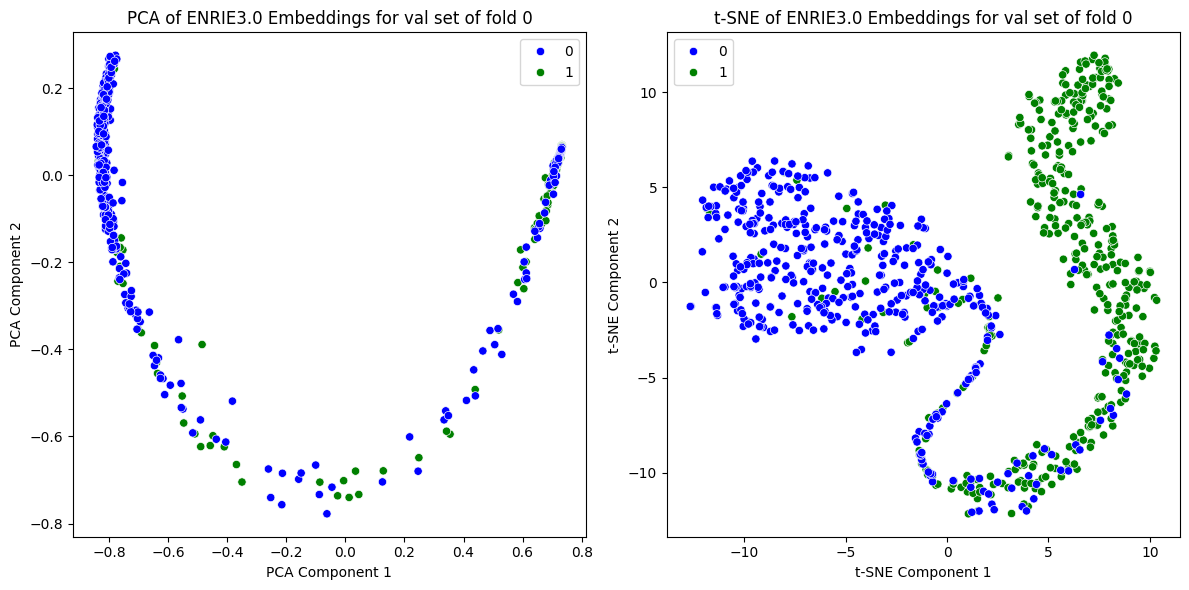

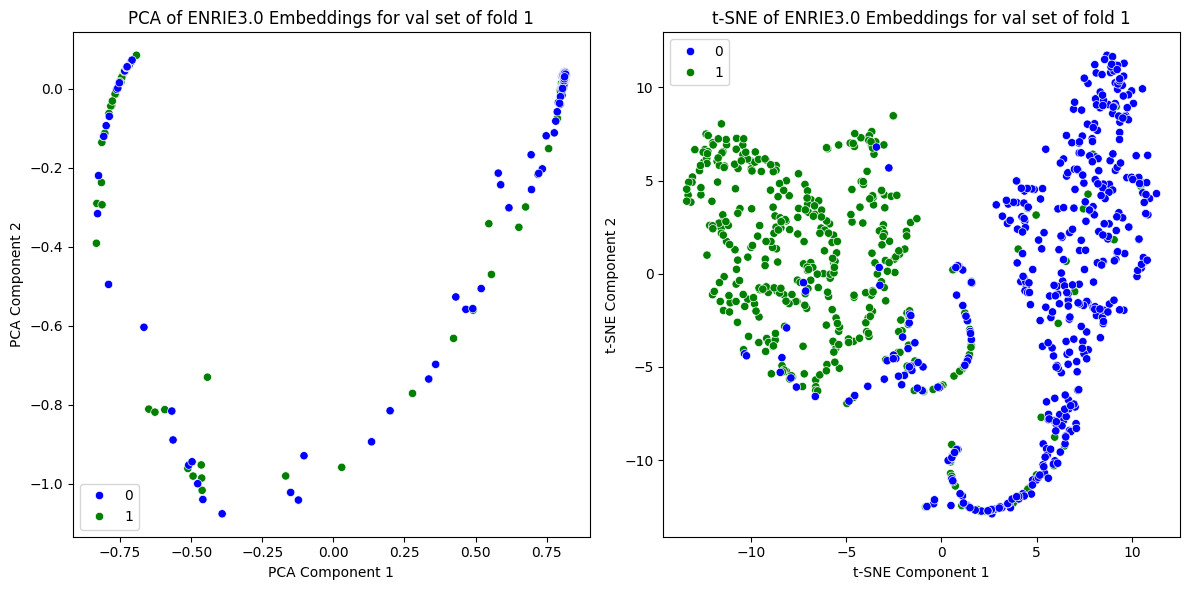

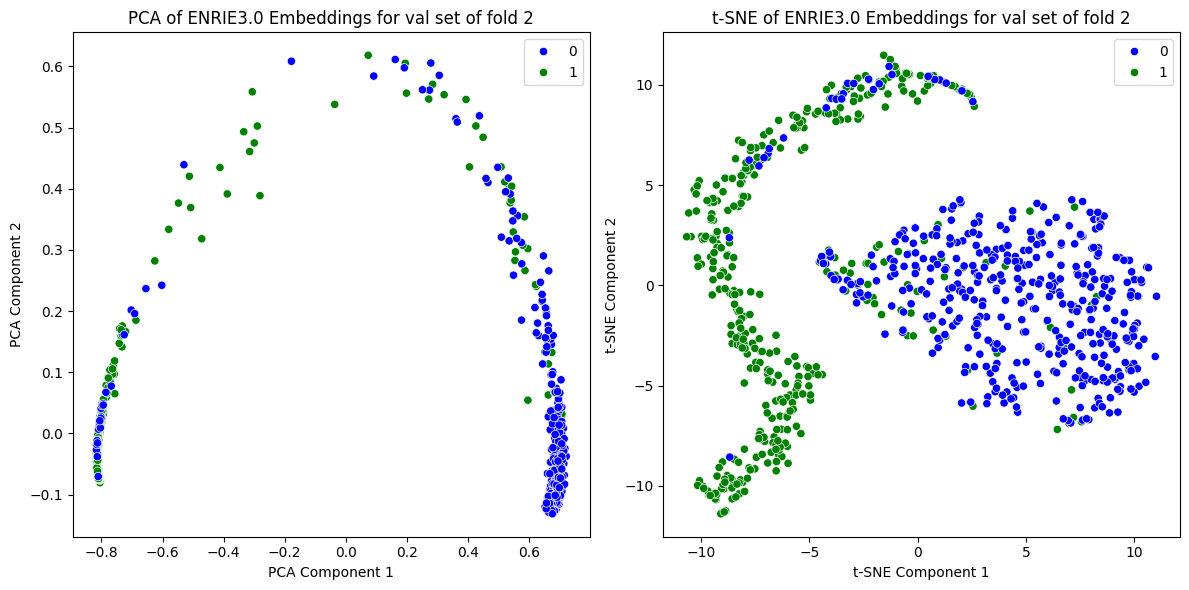

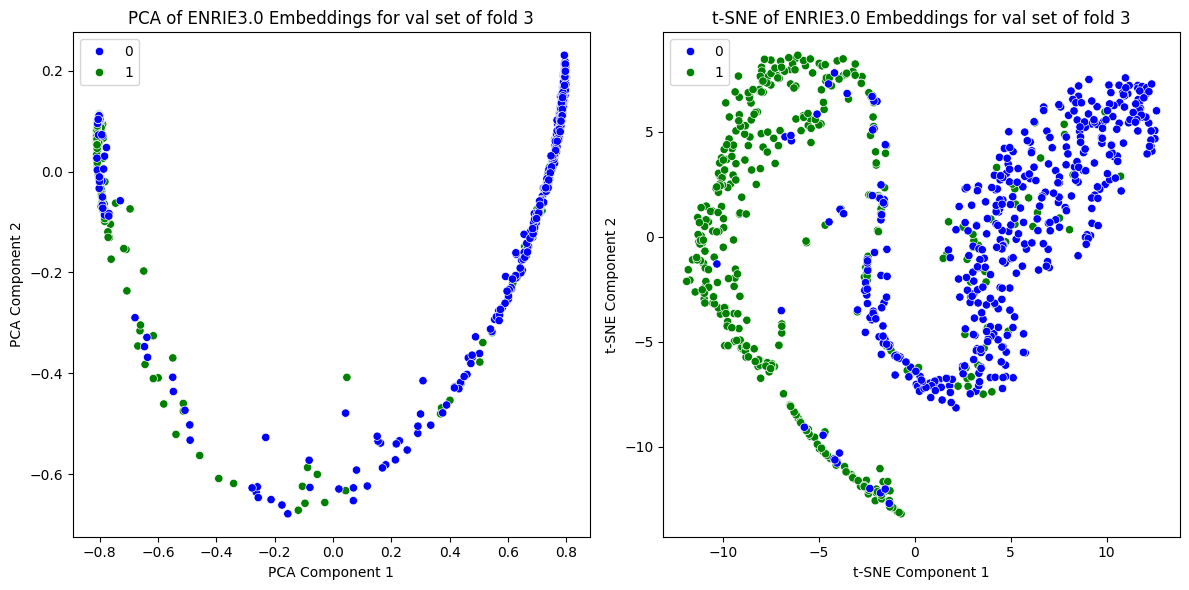

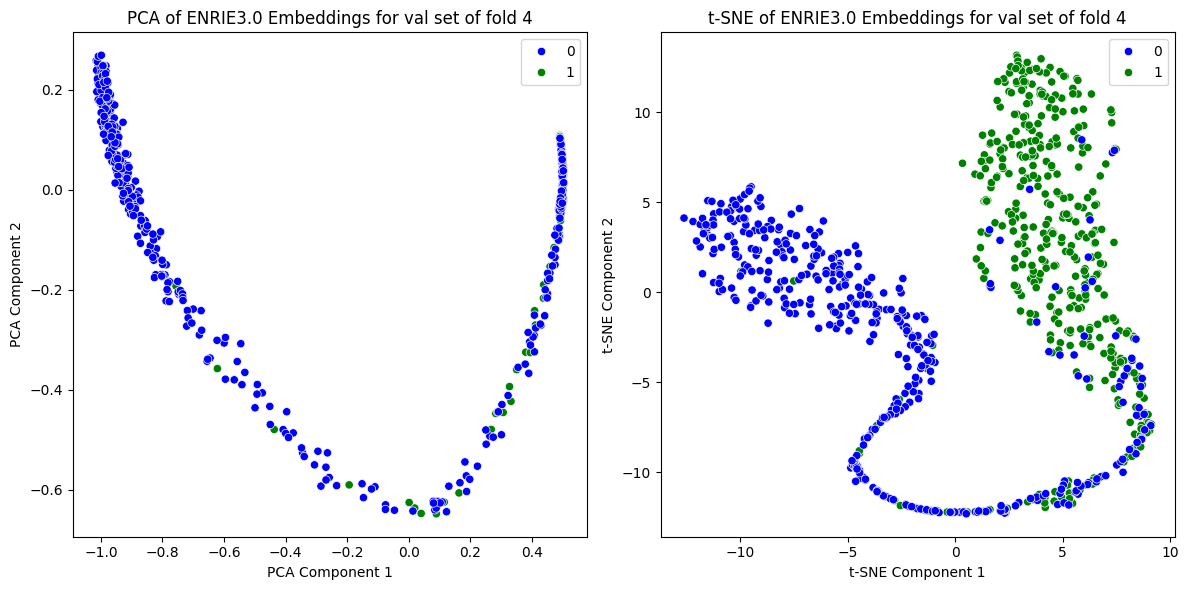

In [42]:
for fold_ids in range(K_FOLDS):
    data_index = fold_idx[fold_ids][1]

    dataset = PolarizationDataset({
        'texts': [df['text'][j] for j in data_index],
        'labels': [df['polarization'][j] for j in data_index]
    }, tokenizer=tokenizer)

    # Create a DataLoader for the training dataset
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE_EVAL, collate_fn=data_collator)

    embeddings, labels = get_embeddings_and_labels(model_list[fold_ids], dataloader)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)

    # Apply t-SNE for dimensionality reduction (can be computationally intensive)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    visualize(f'val set of fold {fold_ids}', pca_embeddings, tsne_embeddings, labels)